C:\Windows\Temp\ipykernel_8896\4277845156.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(feature_path, delim_whitespace=True, header=None)
C:\Windows\Temp\ipykernel_8896\4277845156.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(label_path, delim_whitespace=True, header=None).values.flatten()


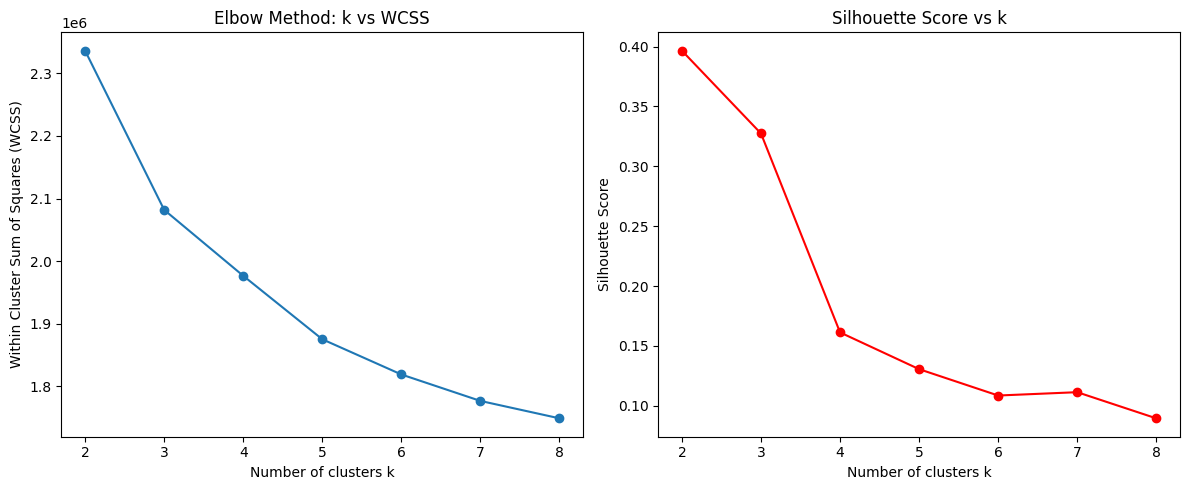

Selected optimal number of clusters k: 2
DBSCAN eps chosen: 2.00, clusters found: 0


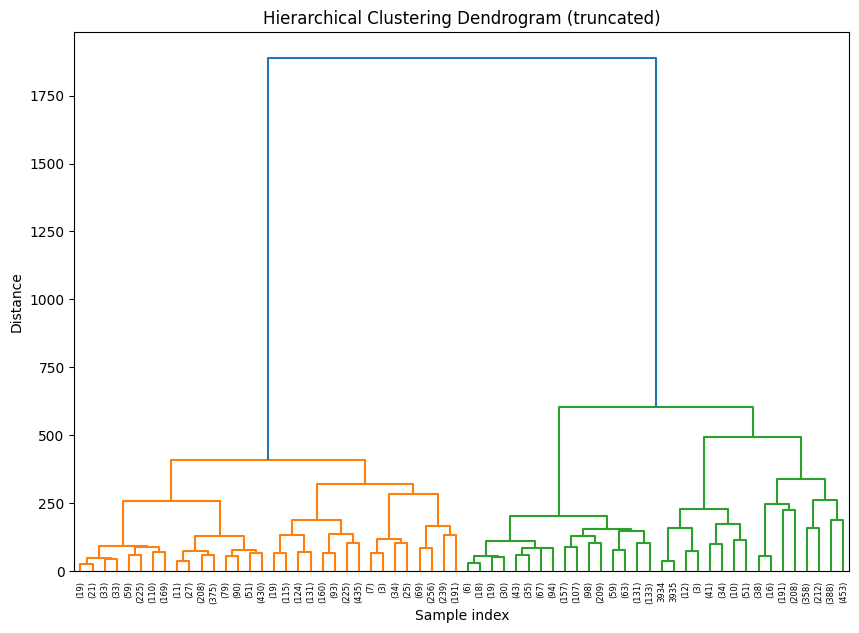

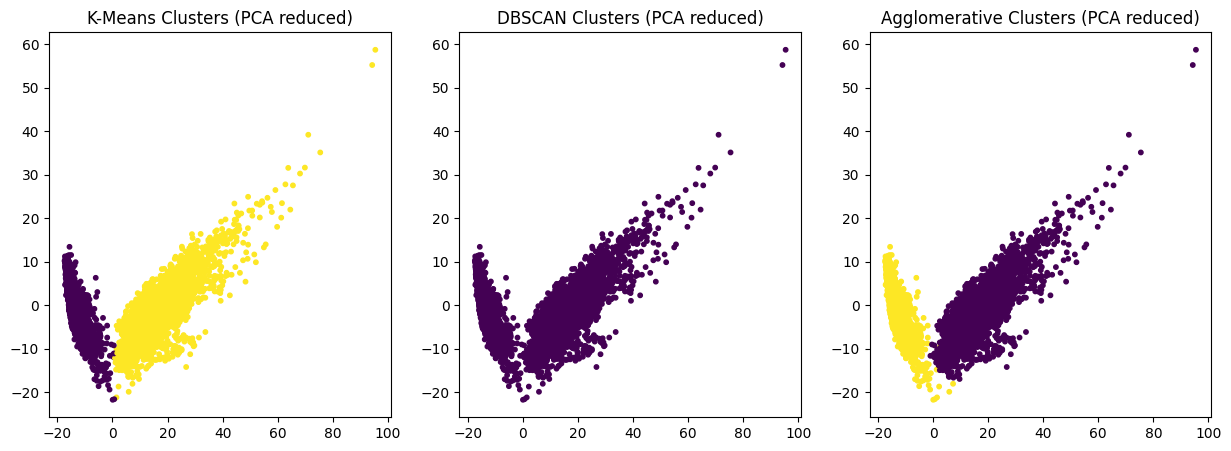

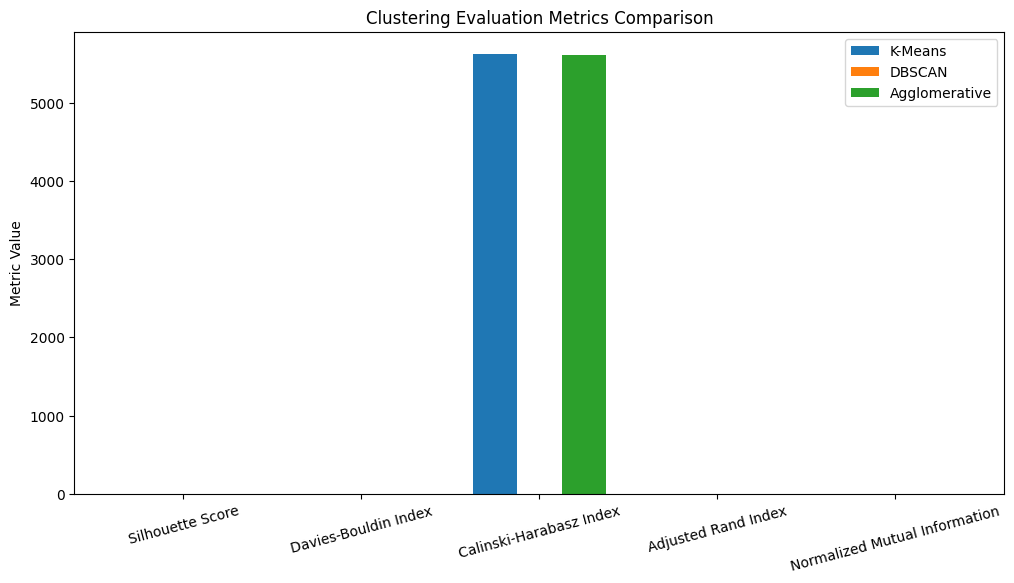

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Function to safely compute cluster evaluation metrics only if more than 1 cluster exists
def safe_evaluate_clustering(true_labels, cluster_labels, data):
    unique_labels = np.unique(cluster_labels)
    results = {}

    if len(unique_labels) > 1:
        results['Silhouette Score'] = silhouette_score(data, cluster_labels)
        results['Davies-Bouldin Index'] = davies_bouldin_score(data, cluster_labels)
        results['Calinski-Harabasz Index'] = calinski_harabasz_score(data, cluster_labels)
        results['Adjusted Rand Index'] = adjusted_rand_score(true_labels, cluster_labels)
        results['Normalized Mutual Information'] = normalized_mutual_info_score(true_labels, cluster_labels)
    else:
        # Invalid clustering (one cluster), set scores to None or default
        results['Silhouette Score'] = None
        results['Davies-Bouldin Index'] = None
        results['Calinski-Harabasz Index'] = None
        results['Adjusted Rand Index'] = None
        results['Normalized Mutual Information'] = None

    return results

# Load the Human Activity Recognition dataset
def load_har_data():
    # Adjust file paths based on dataset location
    feature_path = "./UCI_HAR_Dataset/UCI HAR Dataset/train/X_train.txt"
    label_path = "./UCI_HAR_Dataset/UCI HAR Dataset/train/y_train.txt"
    X_train = pd.read_csv(feature_path, delim_whitespace=True, header=None)
    y_train = pd.read_csv(label_path, delim_whitespace=True, header=None).values.flatten()
    return X_train, y_train

X, y = load_har_data()

# Preprocessing - Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction for visualization (PCA and t-SNE both examples)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# K-Means clustering with Elbow and Silhouette methods to select optimal k
wcss = []
silhouette_scores = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Only calculate metrics if more than 1 cluster found
    if len(np.unique(labels)) > 1:
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
    else:
        wcss.append(None)
        silhouette_scores.append(None)

# Plot Elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method: k vs WCSS')
plt.xlabel('Number of clusters k')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

# Plot Silhouette score curve
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Select best k as the k with max silhouette score ignoring None values
valid_scores = [(k, score) for k, score in zip(k_range, silhouette_scores) if score is not None]
best_k = max(valid_scores, key=lambda x: x[1])[0]
print(f"Selected optimal number of clusters k: {best_k}")

# Run K-Means with best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Try DBSCAN with tunable eps parameter until multiple clusters found
eps_val = 0.5
while True:
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Excluding noise label -1

    if n_clusters_dbscan > 1 or eps_val > 2.0:  # Stop if multiple clusters or eps too large
        break

    eps_val += 0.1  # Increment eps to relax density condition

print(f"DBSCAN eps chosen: {eps_val:.2f}, clusters found: {n_clusters_dbscan}")

# Agglomerative Hierarchical Clustering with Ward linkage
agglo = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled)

# Plot Dendrogram for Hierarchical clustering
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Visualize clusters after PCA - compare algorithms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title('K-Means Clusters (PCA reduced)')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title('DBSCAN Clusters (PCA reduced)')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='viridis', s=10)
plt.title('Agglomerative Clusters (PCA reduced)')

plt.show()

# Compute evaluation metrics safely
kmeans_scores = safe_evaluate_clustering(y, kmeans_labels, X_scaled)
dbscan_scores = safe_evaluate_clustering(y, dbscan_labels, X_scaled)
agglo_scores = safe_evaluate_clustering(y, agglo_labels, X_scaled)

# Prepare for bar plot
metrics = list(kmeans_scores.keys())
kmeans_vals = [kmeans_scores[met] if kmeans_scores[met] is not None else 0 for met in metrics]
dbscan_vals = [dbscan_scores[met] if dbscan_scores[met] is not None else 0 for met in metrics]
agglo_vals = [agglo_scores[met] if agglo_scores[met] is not None else 0 for met in metrics]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, kmeans_vals, width, label='K-Means')
plt.bar(x, dbscan_vals, width, label='DBSCAN')
plt.bar(x + width, agglo_vals, width, label='Agglomerative')

plt.xticks(x, metrics, rotation=15)
plt.title('Clustering Evaluation Metrics Comparison')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Function to calculate all evaluation metrics given true labels, cluster labels, and data features
def evaluate_clustering_all(true_labels, cluster_labels, data):
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) < 2:
        print("Cannot compute metrics: only one cluster found")
        return None

    results = {}
    # Internal metrics (distance-based, no ground truth required)
    results['Silhouette Score'] = silhouette_score(data, cluster_labels)
    results['Davies-Bouldin Index'] = davies_bouldin_score(data, cluster_labels)
    results['Calinski-Harabasz Index'] = calinski_harabasz_score(data, cluster_labels)

    # External metrics (require true labels)
    results['Adjusted Rand Index'] = adjusted_rand_score(true_labels, cluster_labels)
    results['Normalized Mutual Information'] = normalized_mutual_info_score(true_labels, cluster_labels)

    return results

# Optional: Compute confusion matrix by aligning clusters to true labels using Hungarian matching
def cluster_to_label_confusion(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize cm by minimizing negative
    reordered_cm = cm[:, col_ind]
    return reordered_cm, row_ind, col_ind

# Example usage (replace with your variables)
true_labels = y  # true activity labels
cluster_labels = kmeans_labels  # or dbscan_labels or agglo_labels
data = X_scaled  # standardized feature data

# Calculate all metrics
metrics = evaluate_clustering_all(true_labels, cluster_labels, data)
if metrics:
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Compute confusion matrix after mapping clusters to true labels
confusion_mat, row_ind, col_ind = cluster_to_label_confusion(true_labels, cluster_labels)
print("Confusion matrix (aligned clusters -> true labels):")
print(confusion_mat)


Silhouette Score: 0.3965
Davies-Bouldin Index: 1.0688
Calinski-Harabasz Index: 5626.0125
Adjusted Rand Index: 0.3286
Normalized Mutual Information: 0.5438
Confusion matrix (aligned clusters -> true labels):
[[   0    0    0    0    0    0    0]
 [   0 1226    0    0    0    0    0]
 [   0 1066    0    0    0    0    7]
 [   0  986    0    0    0    0    0]
 [   0    1    0    0    0    0 1285]
 [   0    0    0    0    0    0 1374]
 [   0   11    0    0    0    0 1396]]


In [11]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Function to calculate all evaluation metrics given true labels, cluster labels, and data features
def evaluate_clustering_all(true_labels, cluster_labels, data):
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) < 2:
        print("Cannot compute metrics: only one cluster found")
        return None

    results = {}
    # Internal metrics (distance-based, no ground truth required)
    results['Silhouette Score'] = silhouette_score(data, cluster_labels)
    results['Davies-Bouldin Index'] = davies_bouldin_score(data, cluster_labels)
    results['Calinski-Harabasz Index'] = calinski_harabasz_score(data, cluster_labels)

    # External metrics (require true labels)
    results['Adjusted Rand Index'] = adjusted_rand_score(true_labels, cluster_labels)
    results['Normalized Mutual Information'] = normalized_mutual_info_score(true_labels, cluster_labels)

    return results

# Optional: Compute confusion matrix by aligning clusters to true labels using Hungarian matching
def cluster_to_label_confusion(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize cm by minimizing negative
    reordered_cm = cm[:, col_ind]
    return reordered_cm, row_ind, col_ind

# Example usage (replace with your variables)
true_labels = y  # true activity labels
cluster_labels =  agglo_labels
data = X_scaled  # standardized feature data

# Calculate all metrics
metrics = evaluate_clustering_all(true_labels, cluster_labels, data)
if metrics:
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Compute confusion matrix after mapping clusters to true labels
confusion_mat, row_ind, col_ind = cluster_to_label_confusion(true_labels, cluster_labels)
print("Confusion matrix (aligned clusters -> true labels):")
print(confusion_mat)


Silhouette Score: 0.3961
Davies-Bouldin Index: 1.0698
Calinski-Harabasz Index: 5608.2772
Adjusted Rand Index: 0.3319
Normalized Mutual Information: 0.5555
Confusion matrix (aligned clusters -> true labels):
[[   0    0    0    0    0    0    0]
 [   0 1226    0    0    0    0    0]
 [   0 1073    0    0    0    0    0]
 [   0  986    0    0    0    0    0]
 [   0    1    0    0    0    0 1285]
 [   0    0    0    0    0    0 1374]
 [   0    0    0    0    0    0 1407]]


In [16]:
unique, counts = np.unique(dbscan_labels, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(-1): np.int64(7352)}


In [20]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Function to calculate all evaluation metrics given true labels, cluster labels, and data features
def evaluate_clustering_all(true_labels, cluster_labels, data):
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) < 2:
        print("Cannot compute metrics: only one cluster found")
        return None

    results = {}
    # Internal metrics (distance-based, no ground truth required)
    results['Silhouette Score'] = silhouette_score(data, cluster_labels)
    results['Davies-Bouldin Index'] = davies_bouldin_score(data, cluster_labels)
    results['Calinski-Harabasz Index'] = calinski_harabasz_score(data, cluster_labels)

    # External metrics (require true labels)
    results['Adjusted Rand Index'] = adjusted_rand_score(true_labels, cluster_labels)
    results['Normalized Mutual Information'] = normalized_mutual_info_score(true_labels, cluster_labels)

    return results

# Optional: Compute confusion matrix by aligning clusters to true labels using Hungarian matching
def cluster_to_label_confusion(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize cm by minimizing negative
    reordered_cm = cm[:, col_ind]
    return reordered_cm, row_ind, col_ind

# Example usage (replace with your variables)
true_labels = y  # true activity labels
cluster_labels =  dbscan_labels
data = X_scaled  # standardized feature data

# Calculate all metrics
metrics = evaluate_clustering_all(true_labels, cluster_labels, data)
if metrics:
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Compute confusion matrix after mapping clusters to true labels
confusion_mat, row_ind, col_ind = cluster_to_label_confusion(true_labels, cluster_labels)
print("Confusion matrix (aligned clusters -> true labels):")
print(confusion_mat)

Silhouette Score: -0.0430
Davies-Bouldin Index: 3.6104
Calinski-Harabasz Index: 158.3051
Adjusted Rand Index: 0.2978
Normalized Mutual Information: 0.4361
Confusion matrix (aligned clusters -> true labels):
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  2   9 957 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
